# Load Data

In [ ]:
from data_loader import load_data
from features import generate_feature
from models import modeling
from pricing.optimizer import optimize_price_plan
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
df0 = load_data()
df0 = generate_feature(df0)

In [3]:
df0.columns

Index(['date', 'store_id', 'sku_id', 'base_price', 'promo_flag', 'promo_depth',
       'final_price', 'competitor_price', 'holiday_flag', 'weather_index',
       'week_of_year', 'units_sold', 'revenue', 'margin', 'stock_cap',
       'stockout_flag', 'set', 'day_of_week', 'month_of_year', 'season',
       'sold_yesterday', 'sold_last_week', 'final_price_ln',
       'competitor_price_diff', 'onehot_monday', 'onehot_tuesday',
       'onehot_wednesday', 'onehot_thursday', 'onehot_friday',
       'onehot_saturday', 'onehot_sunday', 'onehot_january', 'onehot_february',
       'onehot_march', 'onehot_april', 'onehot_may', 'onehot_june',
       'onehot_july', 'onehot_august', 'onehot_september', 'onehot_october',
       'onehot_november', 'onehot_december', 'onehot_spring', 'onehot_summer',
       'onehot_autumn', 'onehot_winter'],
      dtype='object')

In [4]:
numeric_cols = ['base_price', 'promo_flag', 'promo_depth',
       'final_price', 'competitor_price', 'holiday_flag', 'weather_index',
       'week_of_year', 'units_sold', 'revenue', 'margin', 'stock_cap',
       'stockout_flag', 'sold_yesterday', 'sold_last_week', 'final_price_ln',
       'competitor_price_diff', 'onehot_monday', 'onehot_tuesday',
       'onehot_wednesday', 'onehot_thursday', 'onehot_friday',
       'onehot_saturday', 'onehot_sunday', 'onehot_january', 'onehot_february',
       'onehot_march', 'onehot_april', 'onehot_may', 'onehot_june',
       'onehot_july', 'onehot_august', 'onehot_september', 'onehot_october',
       'onehot_november', 'onehot_december', 'onehot_spring', 'onehot_summer',
       'onehot_autumn', 'onehot_winter']
category_cols = ['store_id', 'sku_id', 'day_of_week', 'month_of_year', 'season']

In [5]:
df0[['date', 'store_id', 'sku_id', 'base_price', 'promo_flag', 'promo_depth',
       'final_price', 'competitor_price', 'holiday_flag', 'weather_index',
       'week_of_year', 'units_sold', 'revenue', 'margin', 'stock_cap',
       'stockout_flag', 'set', 'sold_yesterday', 'sold_last_week',
       'day_of_week', 'month_of_year', 'season',
       'final_price_ln', 'competitor_price_diff']].head()

,date,store_id,sku_id,base_price,promo_flag,promo_depth,final_price,competitor_price,holiday_flag,weather_index,...,stock_cap,stockout_flag,set,sold_yesterday,sold_last_week,day_of_week,month_of_year,season,final_price_ln,competitor_price_diff
0,2024-01-01,S01,SKU001,10.49,0,0.0,10.49,10.02,1,0.291,...,71,0,train,-1,-1,monday,january,winter,2.350422,-0.044805
1,2024-01-01,S01,SKU002,15.49,0,0.0,15.49,15.04,1,0.291,...,78,0,train,-1,-1,monday,january,winter,2.740195,-0.029051
2,2024-01-01,S01,SKU003,21.99,0,0.0,21.99,21.20,1,0.291,...,94,0,train,-1,-1,monday,january,winter,3.090588,-0.035925
3,2024-01-01,S02,SKU001,10.49,1,0.1,9.44,10.30,1,0.291,...,79,0,train,-1,-1,monday,january,winter,2.244956,0.091102
4,2024-01-01,S02,SKU002,15.49,0,0.0,15.49,16.45,1,0.291,...,68,0,train,-1,-1,monday,january,winter,2.740195,0.061975


In [6]:
df0[df0.set == 'train']['date'].max()

Timestamp('2024-09-30 00:00:00')

In [7]:
df0[df0.set == 'test']['date'].min()

Timestamp('2024-10-01 00:00:00')

- The model will be unable to model the seasonality effect of Oct, Nov, Dec
- For product that is strongly affected by seasons, overfit can occur

# EDA
- Identify main demand drivers (price, promo, holiday, weather, weekly/annual patterns, store effects).
- Check price elasticity by SKU and promo effect sizes.
- Detect stockouts and discuss their impact on demand estimation.

## Quick check datastats

In [8]:
# we dont want stockout to negatively affect model performance
df = df0[df0.stockout_flag == 0].reset_index(drop = True).copy()

In [9]:
# there are still enough sample size after excluding stock out days
df.groupby(['store_id','sku_id'])['units_sold'].count()

store_id  sku_id
S01       SKU001    354
          SKU002    355
          SKU003    348
S02       SKU001    341
          SKU002    336
          SKU003    338
S03       SKU001    329
          SKU002    323
          SKU003    334
S04       SKU001    310
          SKU002    303
          SKU003    311
S05       SKU001    284
          SKU002    296
          SKU003    301
Name: units_sold, dtype: Int64

In [10]:
df.groupby(['store_id','sku_id'])['units_sold'].mean()

store_id  sku_id
S01       SKU001    17.926554
          SKU002    18.611268
          SKU003    16.227011
S02       SKU001    21.357771
          SKU002    22.458333
          SKU003    20.171598
S03       SKU001    26.194529
          SKU002    26.885449
          SKU003    23.302395
S04       SKU001    30.974194
          SKU002    31.518152
          SKU003    27.192926
S05       SKU001    34.147887
          SKU002    35.081081
          SKU003    31.813953
Name: units_sold, dtype: Float64

In [28]:
df.groupby(['store_id','sku_id'])['stock_cap'].mean()

store_id  sku_id
S01       SKU001     64.70339
          SKU002    63.997183
          SKU003    64.793103
S02       SKU001    65.821114
          SKU002    64.571429
          SKU003    63.470414
S03       SKU001    64.978723
          SKU002    65.473684
          SKU003    67.311377
S04       SKU001    70.919355
          SKU002    68.891089
          SKU003    67.376206
S05       SKU001    68.140845
          SKU002    69.804054
          SKU003    64.750831
Name: stock_cap, dtype: Float64

In [11]:
df.groupby(['store_id','sku_id'])['base_price'].mean()

store_id  sku_id
S01       SKU001    10.49
          SKU002    15.49
          SKU003    21.99
S02       SKU001    10.49
          SKU002    15.49
          SKU003    21.99
S03       SKU001    10.49
          SKU002    15.49
          SKU003    21.99
S04       SKU001    10.49
          SKU002    15.49
          SKU003    21.99
S05       SKU001    10.49
          SKU002    15.49
          SKU003    21.99
Name: base_price, dtype: float64

- Sales Store 5 > Store 4 > Store 3 > Store 2 > Store 1
- Need to distinguish 5 stores in the analysis and modeling

In [12]:
stores = list(df['store_id'].unique())
skus = list(df['sku_id'].unique())

In [13]:
stores

['S01', 'S02', 'S03', 'S04', 'S05']

In [14]:
skus

['SKU001', 'SKU002', 'SKU003']

### Price ~ Demand
There is a negative relationship

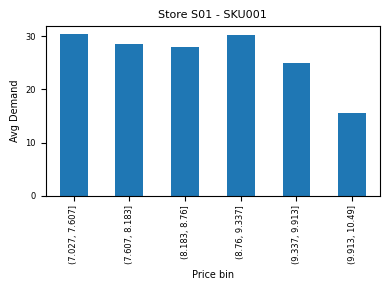

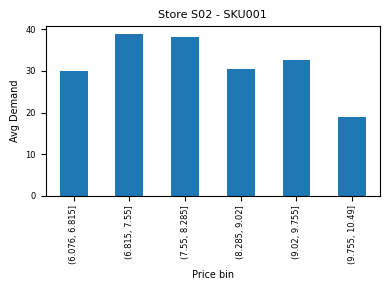

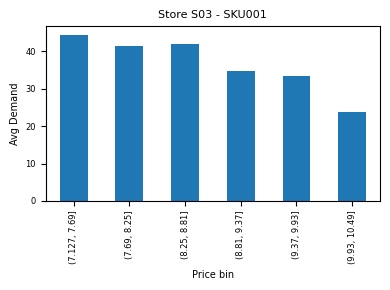

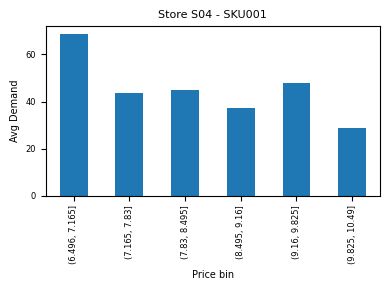

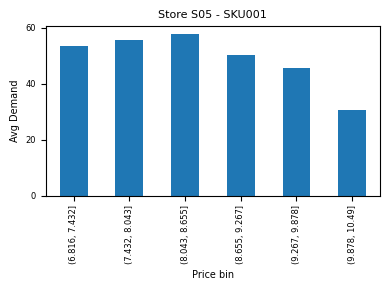

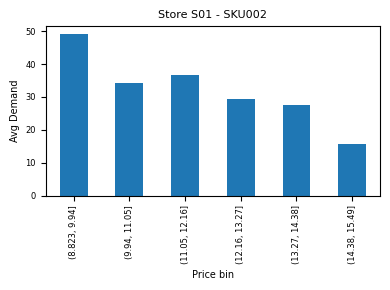

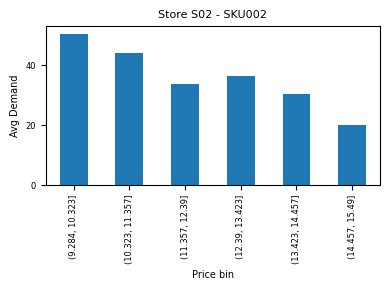

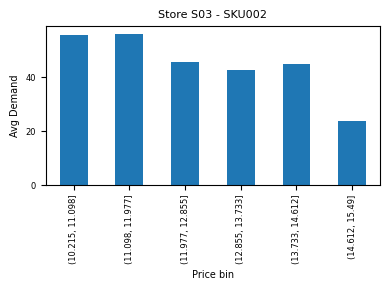

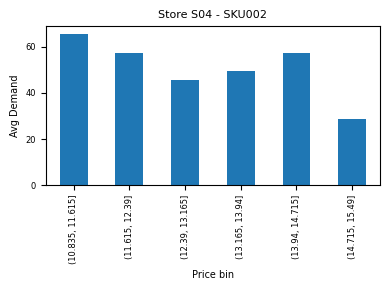

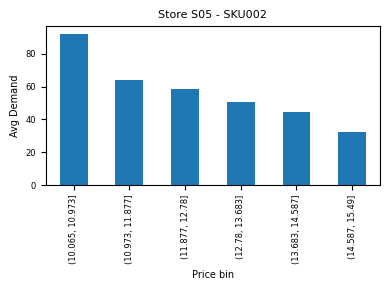

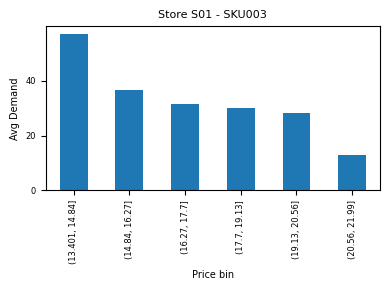

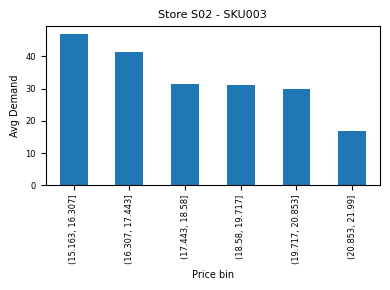

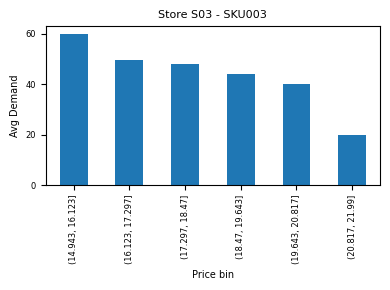

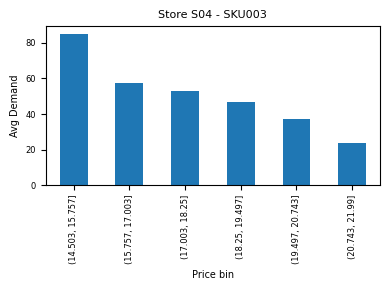

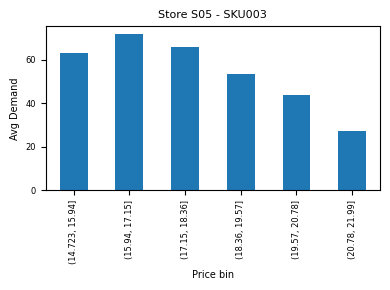

In [15]:
for sk in skus:
    for st in stores:
        df_price = df[(df.store_id == st) & (df.sku_id == sk)]
        min_price = df_price['final_price'].min()
        max_price = df_price['final_price'].max()
        if df_price.empty: 
            pass
        else:
            avg = df_price.groupby(pd.cut(df_price["final_price"], bins=6))["units_sold"].mean()
            plt.figure(figsize=(4,3))
            avg.plot(kind="bar")
            plt.title(f"Store {st} - {sk}", fontsize=8)
            plt.xlabel("Price bin", fontsize=7)
            plt.ylabel("Avg Demand", fontsize=7)
            plt.xticks(fontsize=6)
            plt.yticks(fontsize=6)
            plt.tight_layout()
            plt.show()

### Promo ~ Demand
Overall, bigger promotion percentage does drive bigger sales, same effect on all skus and stores

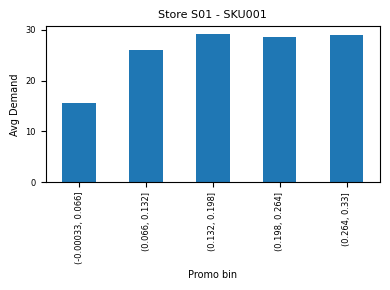

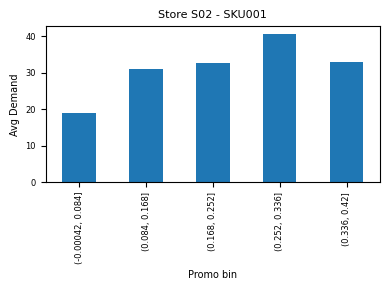

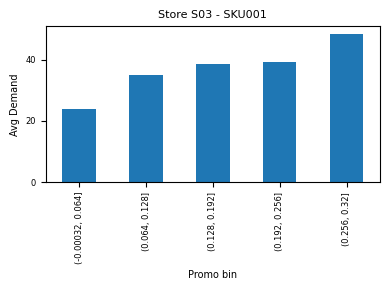

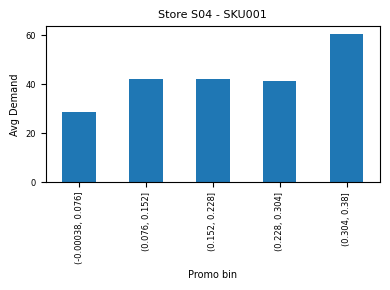

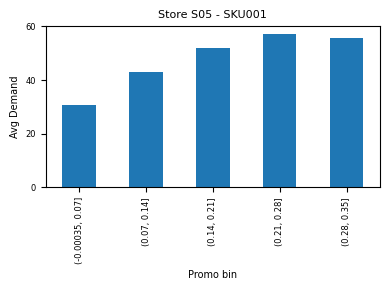

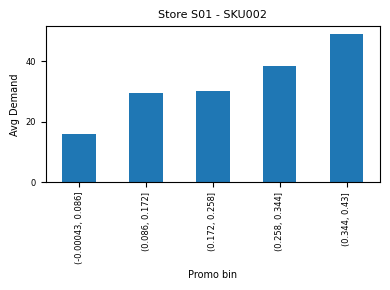

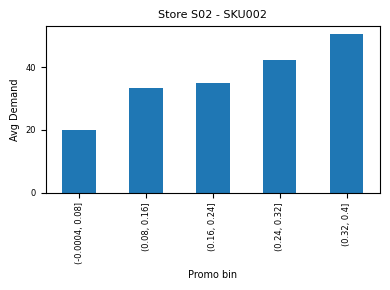

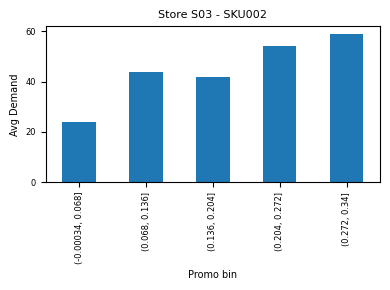

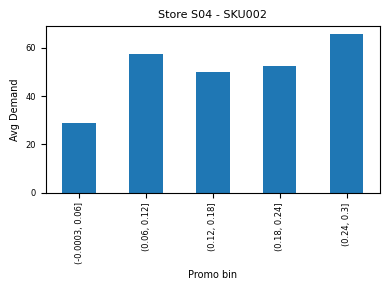

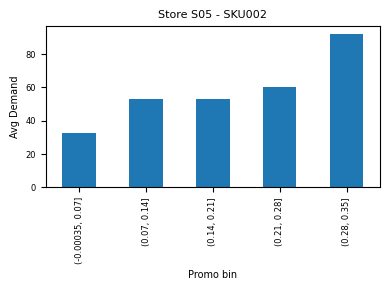

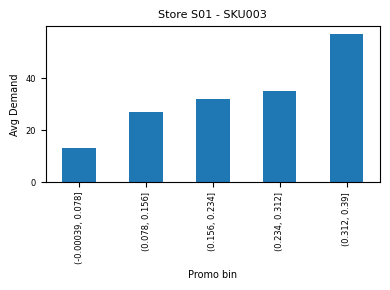

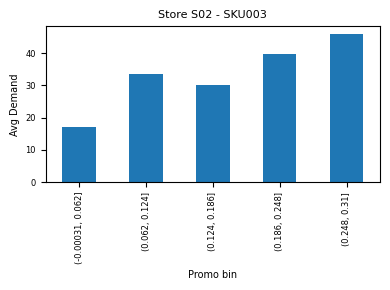

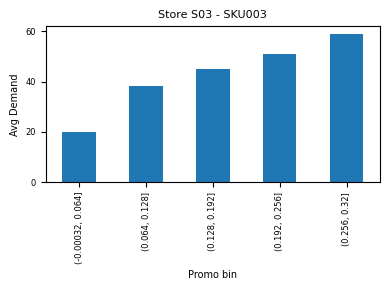

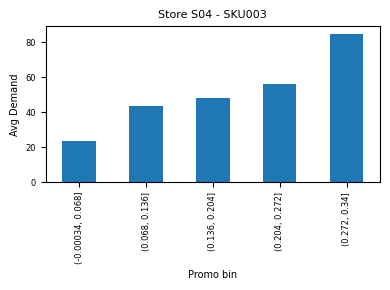

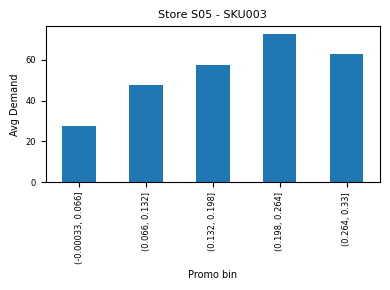

In [16]:
for sk in skus:
    for st in stores:
        df_price = df[(df.store_id == st) & (df.sku_id == sk)]
        if df_price.empty: 
            pass
        else:
            avg = df_price.groupby(pd.cut(df_price["promo_depth"], bins=5))["units_sold"].mean()
            plt.figure(figsize=(4,3)); avg.plot(kind="bar")
            plt.title(f"Store {st} - {sk}", fontsize=8)
            plt.xlabel("Promo bin", fontsize=7)
            plt.ylabel("Avg Demand", fontsize=7)
            plt.xticks(fontsize=6)
            plt.yticks(fontsize=6)
            plt.tight_layout()
            plt.show()

### Holiday ~ Demand
Sometimes non-holiday days sell more, could be because of promotion

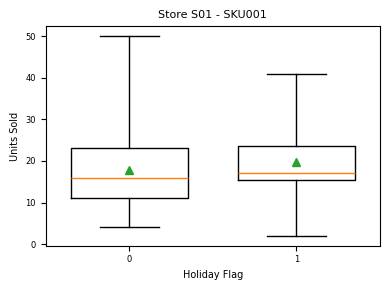

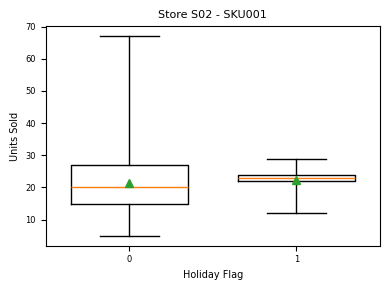

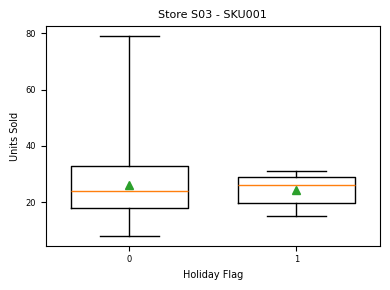

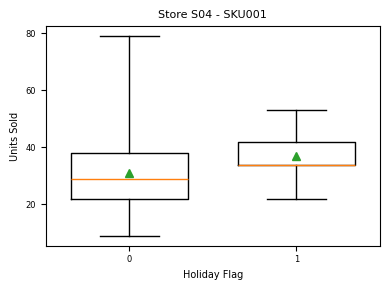

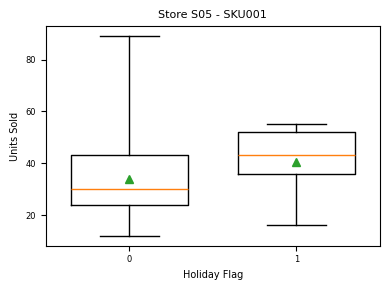

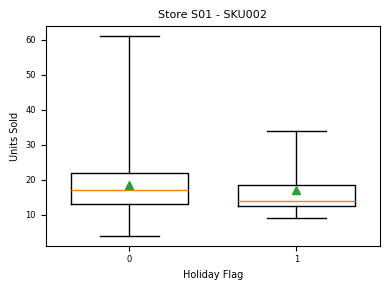

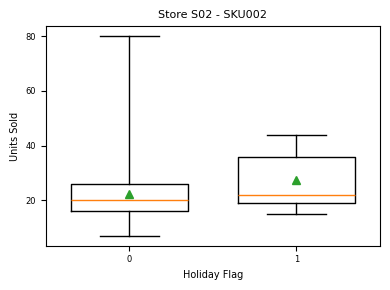

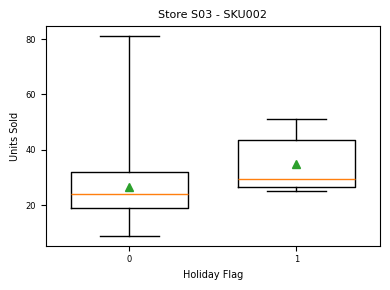

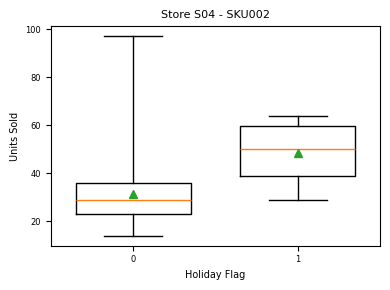

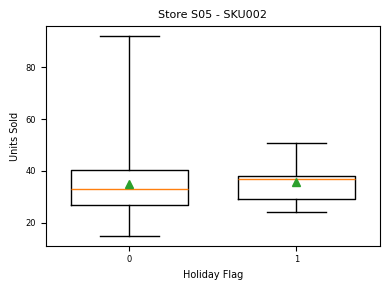

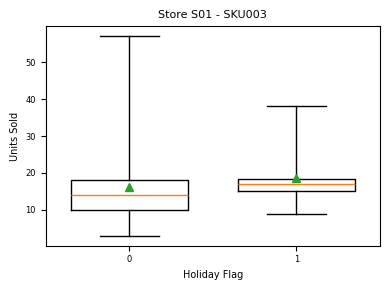

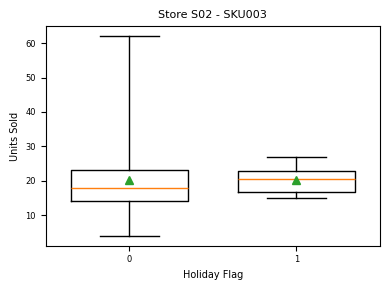

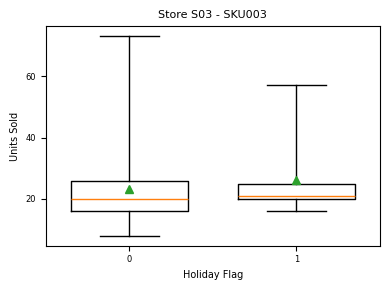

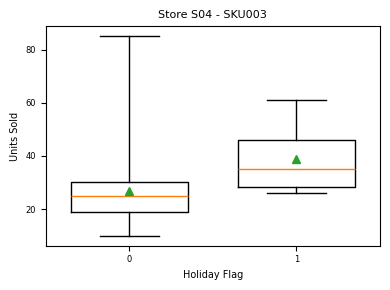

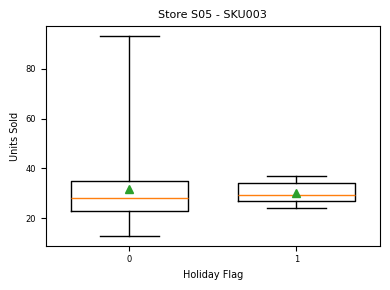

In [17]:
for sk in skus:
    for st in stores:
        df_price = df[(df.store_id == st) & (df.sku_id == sk)]
        if df_price.empty: 
            pass
        else:
            keys = sorted(df_price["holiday_flag"].dropna().unique())
            data = [df_price.loc[df_price["holiday_flag"]==k, "units_sold"].values for k in keys]
            plt.figure(figsize=(4,3))
            plt.boxplot(data, widths=0.7, labels=[str(int(k)) for k in keys], showmeans=True, whis=[0,100])
            plt.title(f"Store {st} - {sk}", fontsize=8)
            plt.xlabel("Holiday Flag", fontsize=7)
            plt.ylabel("Units Sold", fontsize=7)
            plt.xticks(fontsize=6)
            plt.yticks(fontsize=6)
            plt.tight_layout()
            plt.show()

### Weather ~ Demand

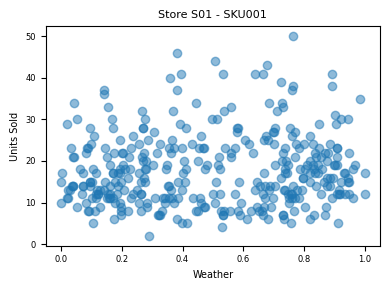

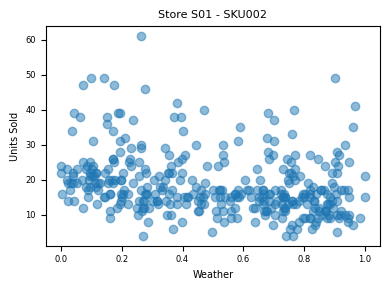

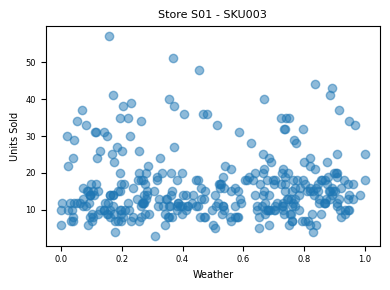

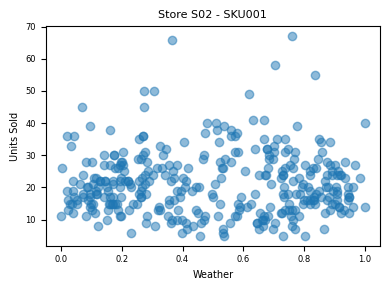

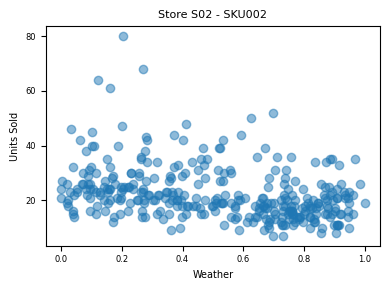

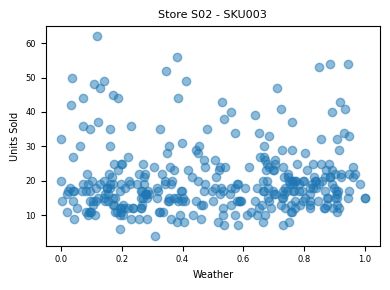

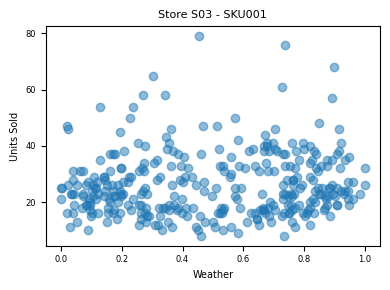

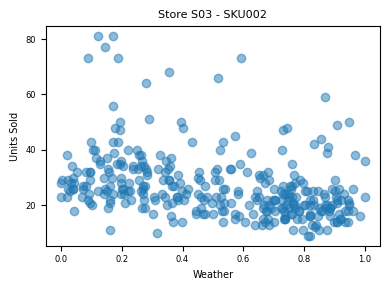

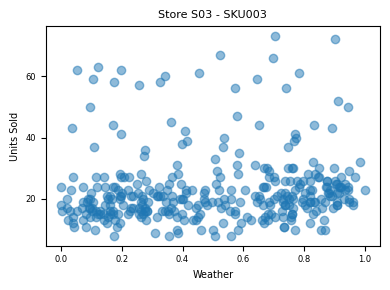

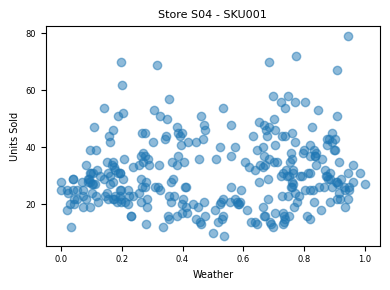

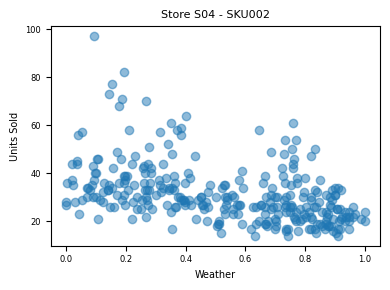

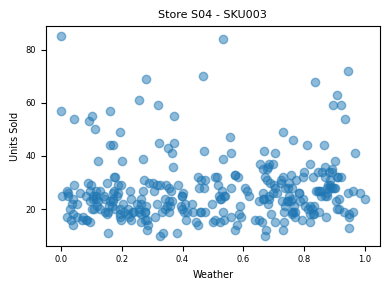

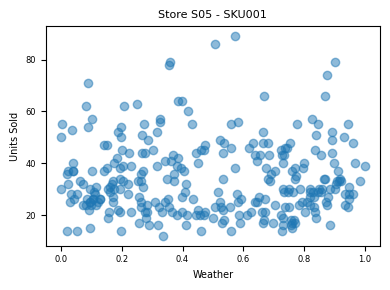

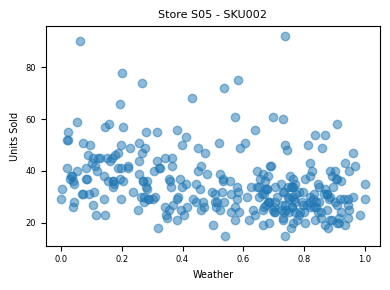

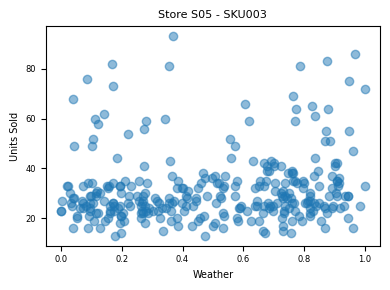

In [18]:
for st in stores:
    for sk in skus:
        df_price = df[(df.store_id == st) & (df.sku_id == sk)]
        if df_price.empty: 
            pass
        else:
            plt.figure(figsize=(4,3))
            plt.scatter(x=df_price.weather_index, y=df_price.units_sold, alpha = 0.5)
            plt.title(f"Store {st} - {sk}", fontsize=8)
            plt.xlabel("Weather", fontsize=7)
            plt.ylabel("Units Sold", fontsize=7)
            plt.xticks(fontsize=6)
            plt.yticks(fontsize=6)
            plt.tight_layout()
            plt.show()

### Annual patterns ~ Demand

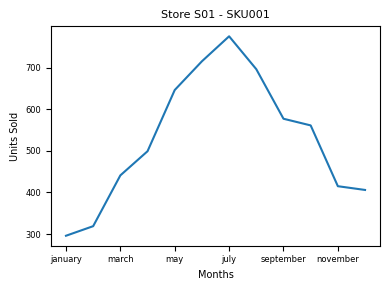

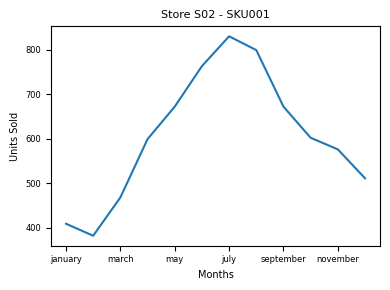

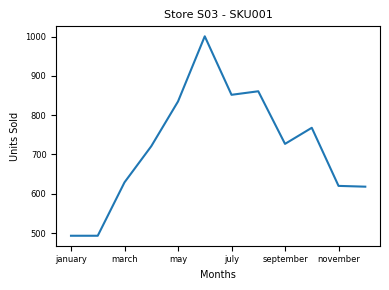

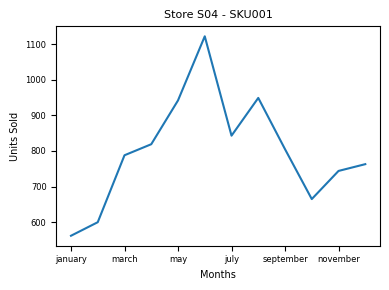

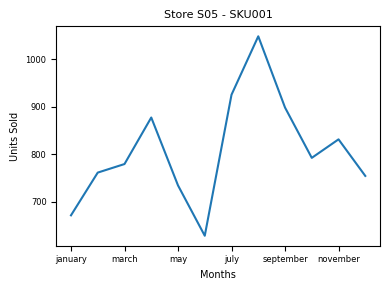

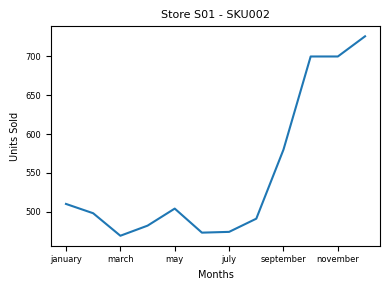

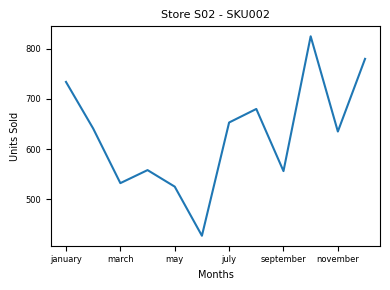

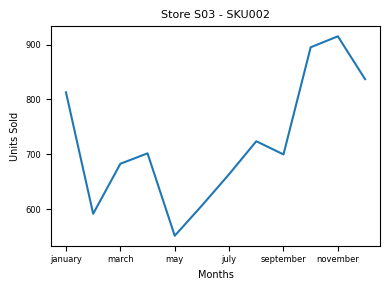

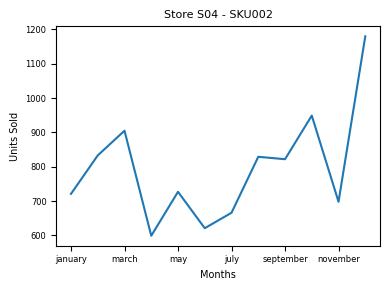

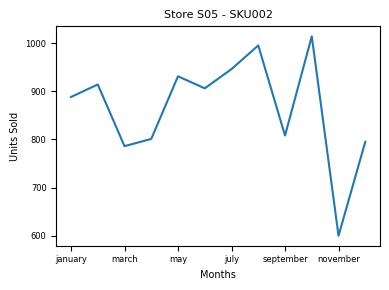

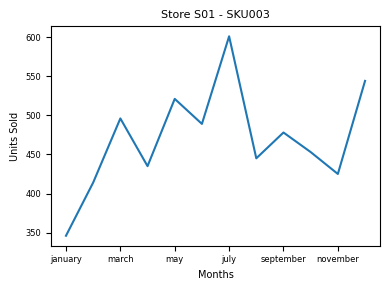

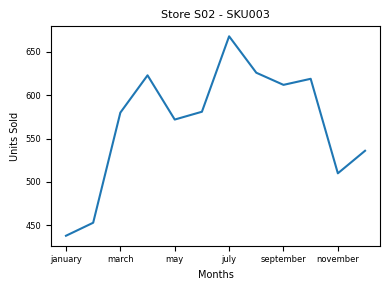

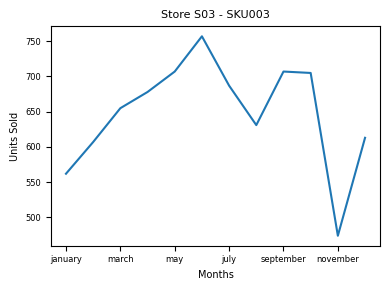

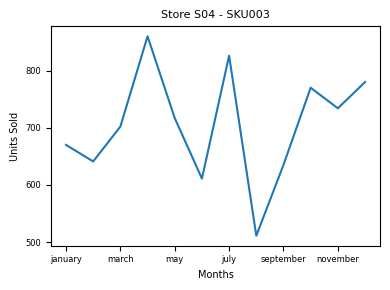

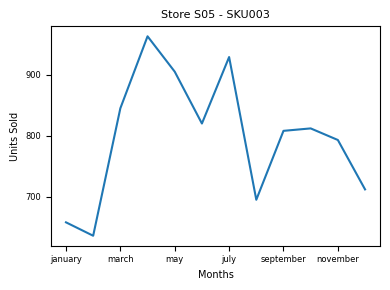

In [19]:
for sk in skus:
    for st in stores:
        df_price = df[(df.store_id == st) & (df.sku_id == sk)]
        if df_price.empty: 
            pass
        else:
            avg = df_price.groupby('month_of_year')["units_sold"].sum()
            plt.figure(figsize=(4,3))
            avg.plot(kind="line")
            plt.title(f"Store {st} - {sk}", fontsize=8)
            plt.xlabel("Months", fontsize=7)
            plt.ylabel("Units Sold", fontsize=7)
            plt.xticks(fontsize=6)
            plt.yticks(fontsize=6)
            plt.tight_layout()
            plt.show()

### Weekly patterns ~ Demand

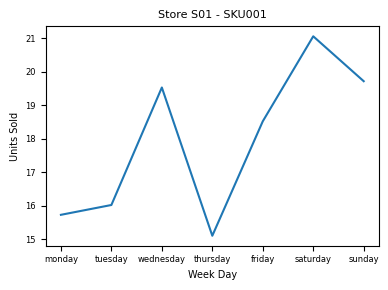

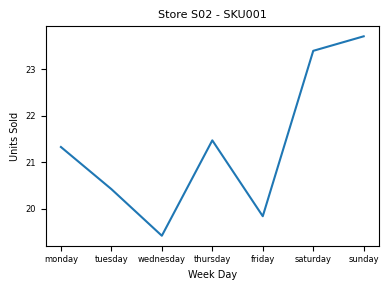

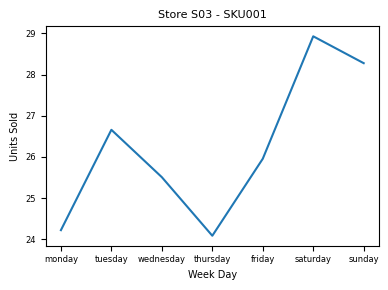

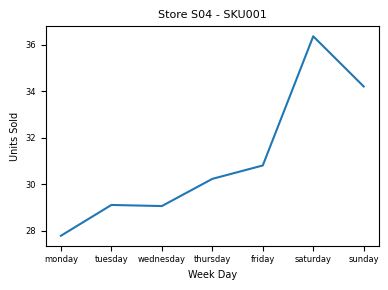

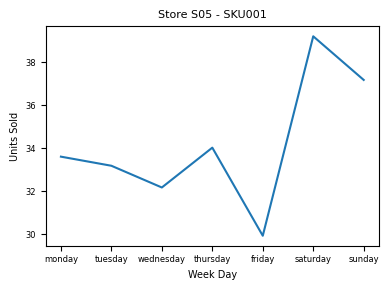

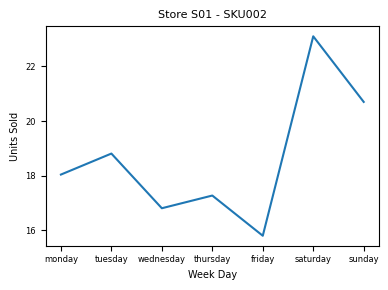

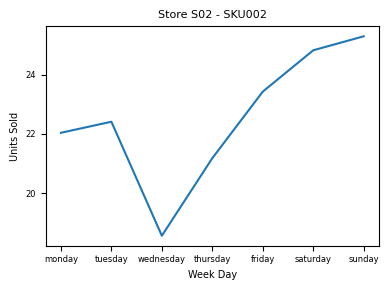

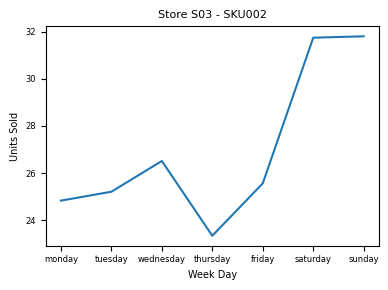

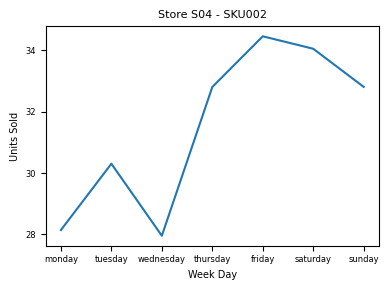

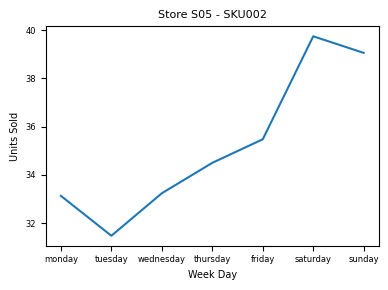

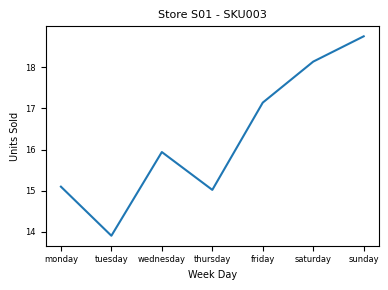

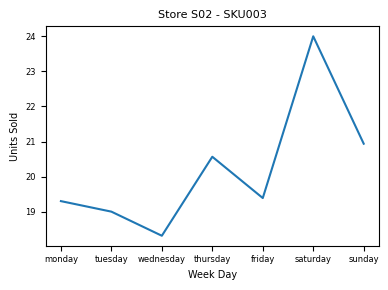

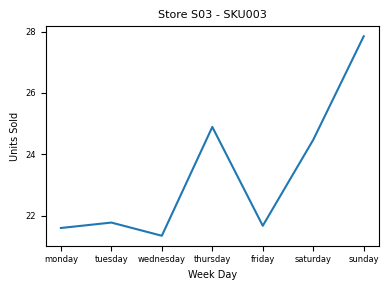

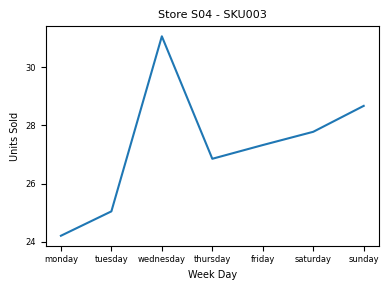

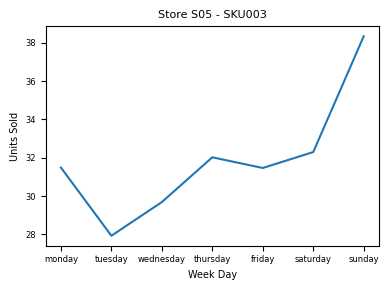

In [20]:
for sk in skus:
    for st in stores:
        df_price = df[(df.store_id == st) & (df.sku_id == sk)]
        if df_price.empty: 
            pass
        else:
            avg = df_price.groupby('day_of_week')["units_sold"].mean()
            plt.figure(figsize=(4,3))
            avg.plot(kind="line")
            plt.title(f"Store {st} - {sk}", fontsize=8)
            plt.xlabel("Week Day", fontsize=7)
            plt.ylabel("Units Sold", fontsize=7)
            plt.xticks(fontsize=6)
            plt.yticks(fontsize=6)
            plt.tight_layout()
            plt.show()

## Price Elasticity
price elasticity by SKU and promo effect sizes

In [21]:
for sk in skus:
    print(f'Check {sk} price sensitivity:')

    d = df[(df.sku_id == sk)].reset_index(drop = True).copy()
    d["ln_units"] = np.log(d["units_sold"])
    
    # calendar controls you kept (already removed Sunday/December)
    calendar = [
        'onehot_monday','onehot_tuesday','onehot_wednesday','onehot_thursday','onehot_friday','onehot_saturday',
        'onehot_january','onehot_february','onehot_march','onehot_april','onehot_may','onehot_june',
        'onehot_july','onehot_august','onehot_september','onehot_october','onehot_november'
    ]
    # keep only those that exist
    calendar = [c for c in calendar if c in d.columns]
    
    # feature matrix
    cols = ["final_price_ln", "promo_flag", "holiday_flag", "competitor_price_diff",] + calendar
    X = d[cols].values
    y = d["ln_units"].values
    
    # fit OLS via scikit-learn
    model = LinearRegression(fit_intercept=True).fit(X, y)
    coef = dict(zip(cols, model.coef_))
    
    # effects
    price_elast   = coef["final_price_ln"]
    promo_effect_size   = (np.exp(coef["promo_flag"]) - 1) * 100            # % lift when promo_flag=1
    
    print(f"Price elasticity: {price_elast:.3f}")
    print(f"Promo effect size (%): {promo_effect_size:.2f} \n")
    print(coef, '\n')
    # break

Check SKU001 price sensitivity:
Price elasticity: -0.325
Promo effect size (%): 27.77 

{'final_price_ln': np.float64(-0.3254197527656831), 'promo_flag': np.float64(0.24508644575040126), 'holiday_flag': np.float64(0.19136123904753552), 'competitor_price_diff': np.float64(0.919085736103544), 'onehot_monday': np.float64(-0.14573041650184798), 'onehot_tuesday': np.float64(-0.15440965415475488), 'onehot_wednesday': np.float64(-0.15041831916637838), 'onehot_thursday': np.float64(-0.15236763034845643), 'onehot_friday': np.float64(-0.15972285290539942), 'onehot_saturday': np.float64(0.01579183456447318), 'onehot_january': np.float64(-0.3012183445443937), 'onehot_february': np.float64(-0.22508014973687426), 'onehot_march': np.float64(-0.010797756447906958), 'onehot_april': np.float64(0.1906534820865761), 'onehot_may': np.float64(0.39291897256461733), 'onehot_june': np.float64(0.6007435825120021), 'onehot_july': np.float64(0.6650486151810933), 'onehot_august': np.float64(0.5988503306222179), 'o

- Price sensitivity: SKU003 > SKU002 > SKU001
- SKU001 is insensitive to price change, but its demand is heavily affected by seasons, especially high coefficient in the summer months

# Baseline forecasting model

In [16]:
df.columns

Index(['date', 'store_id', 'sku_id', 'base_price', 'promo_flag', 'promo_depth',
       'final_price', 'competitor_price', 'holiday_flag', 'weather_index',
       'week_of_year', 'units_sold', 'revenue', 'margin', 'stock_cap',
       'stockout_flag', 'set', 'day_of_week', 'month_of_year', 'season',
       'sold_yesterday', 'sold_last_week', 'final_price_ln',
       'competitor_price_diff', 'onehot_monday', 'onehot_tuesday',
       'onehot_wednesday', 'onehot_thursday', 'onehot_friday',
       'onehot_saturday', 'onehot_sunday', 'onehot_january', 'onehot_february',
       'onehot_march', 'onehot_april', 'onehot_may', 'onehot_june',
       'onehot_july', 'onehot_august', 'onehot_september', 'onehot_october',
       'onehot_november', 'onehot_december', 'onehot_spring', 'onehot_summer',
       'onehot_autumn', 'onehot_winter'],
      dtype='object')

In [17]:
feature_cols = ['store_id', 'sku_id', 'base_price', 'promo_flag', 'promo_depth',
       'final_price', 'competitor_price', 'holiday_flag', 'weather_index',
       'day_of_week', 'month_of_year', 'season',
       'sold_yesterday', 'sold_last_week', 'final_price_ln',
       'competitor_price_diff']
target_col = 'units_sold'
split_col = 'set'

In [18]:
# df already excluded the stock out
X_train = df[df[split_col] == 'train'][feature_cols]
y_train = df[df[split_col] == 'train'][target_col]
X_test = df[df[split_col] == 'test'][feature_cols]
y_test = df[df[split_col] == 'test'][target_col]

In [19]:
modeling.fit(X_train, y_train)

[0]	validation_0-rmse:12.61586
[1]	validation_0-rmse:12.21462
[2]	validation_0-rmse:11.86955
[3]	validation_0-rmse:11.55845
[4]	validation_0-rmse:11.36930
[5]	validation_0-rmse:11.10439
[6]	validation_0-rmse:10.83120
[7]	validation_0-rmse:10.58645
[8]	validation_0-rmse:10.35642
[9]	validation_0-rmse:10.14195
[10]	validation_0-rmse:9.94300
[11]	validation_0-rmse:9.73907
[12]	validation_0-rmse:9.52906
[13]	validation_0-rmse:9.38530
[14]	validation_0-rmse:9.20046
[15]	validation_0-rmse:9.05110
[16]	validation_0-rmse:8.89351
[17]	validation_0-rmse:8.74594
[18]	validation_0-rmse:8.61833
[19]	validation_0-rmse:8.50032
[20]	validation_0-rmse:8.36824
[21]	validation_0-rmse:8.25612
[22]	validation_0-rmse:8.16732
[23]	validation_0-rmse:8.07564
[24]	validation_0-rmse:7.99749
[25]	validation_0-rmse:7.92629
[26]	validation_0-rmse:7.85846
[27]	validation_0-rmse:7.78912
[28]	validation_0-rmse:7.70259
[29]	validation_0-rmse:7.64922
[30]	validation_0-rmse:7.59607
[31]	validation_0-rmse:7.54042
[32]	val

'forecaster_xgboost_20250909_221509.pkl'

In [20]:
modeling.validate('forecaster_xgboost_20250909_221509.pkl', X_train, y_train)

Validation metrics for forecaster_xgboost_20250909_221509.pkl:
  R^2  : 0.9039
  RMSE : 3.842168
  MAPE : 14.09%


{'r2': 0.903924822807312,
 'rmse': 3.8421677224734982,
 'mape_pct': 14.08504885717507}

In [21]:
modeling.validate('forecaster_xgboost_20250909_221509.pkl', X_test, y_test)

Validation metrics for forecaster_xgboost_20250909_221509.pkl:
  R^2  : 0.6327
  RMSE : 8.088119
  MAPE : 26.04%


{'r2': 0.6326841115951538,
 'rmse': 8.088119138811772,
 'mape_pct': 26.039592411348}

- There is a clear overfitting sight due to unable to model the seasonality

In [22]:
modeling.validate('forecaster_xgboost_20250909_221509.pkl', df[(df[split_col] == 'test') & (df.sku_id == 'SKU001')][feature_cols], df[(df[split_col] == 'test') & (df.sku_id == 'SKU001')][target_col])

Validation metrics for forecaster_xgboost_20250909_221509.pkl:
  R^2  : 0.5558
  RMSE : 6.671185
  MAPE : 27.84%


{'r2': 0.5557771921157837,
 'rmse': 6.671185424332044,
 'mape_pct': 27.844989398071224}

In [23]:
modeling.validate('forecaster_xgboost_20250909_221509.pkl', df[(df[split_col] == 'test') & (df.sku_id == 'SKU002')][feature_cols], df[(df[split_col] == 'test') & (df.sku_id == 'SKU002')][target_col])

Validation metrics for forecaster_xgboost_20250909_221509.pkl:
  R^2  : 0.3005
  RMSE : 11.417425
  MAPE : 25.05%


{'r2': 0.3004785180091858,
 'rmse': 11.417425497040423,
 'mape_pct': 25.054945395767724}

In [24]:
modeling.validate('forecaster_xgboost_20250909_221509.pkl', df[(df[split_col] == 'test') & (df.sku_id == 'SKU003')][feature_cols], df[(df[split_col] == 'test') & (df.sku_id == 'SKU003')][target_col])

Validation metrics for forecaster_xgboost_20250909_221509.pkl:
  R^2  : 0.8189
  RMSE : 5.571641
  MAPE : 25.04%


{'r2': 0.8189440369606018,
 'rmse': 5.5716412472218755,
 'mape_pct': 25.04420586816562}

# Optimizer
Maximize revenue subject to price bounds & promo constraints

In [25]:
price_plan = optimize_price_plan('submission/src/models/forecaster_xgboost_20250909_221509.pkl', '2024-03-01', 30)
price_plan

=== Optimization Summary ===
Horizon days         : 30
Date range           : 2024-03-01 → 2024-03-30
Total baseline rev   : 91,967.46
Total optimized rev  : 103,986.92
Revenue lift         : 12,019.46 (13.07%)
Exported price plan to C:\Users\thi.n\Documents\Projects\simcel\submission\src\pricing\price_plan_20240301_30days_20250909_221638.csv


,date,store_id,sku_id,final_price,promo_depth,pred_units,revenue,is_promo,baseline_price,baseline_units,baseline_revenue,uplift_revenue
0,2024-03-01,S01,SKU001,10.490000,0.000000,12.515466,131.287236,0,10.49,12.515466,131.287236,0.000000
1,2024-03-01,S01,SKU002,15.490000,0.000000,12.488720,193.450272,0,15.49,12.488720,193.450272,0.000000
2,2024-03-01,S01,SKU003,21.990000,0.000000,12.281407,270.068148,0,21.99,12.281407,270.068148,0.000000
3,2024-03-01,S02,SKU001,10.490000,0.000000,12.515466,131.287236,0,10.49,12.515466,131.287236,0.000000
4,2024-03-01,S02,SKU002,15.490000,0.000000,12.488720,193.450272,0,15.49,12.488720,193.450272,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
445,2024-03-30,S04,SKU002,13.424667,0.133333,26.759043,359.231229,1,15.49,14.496677,224.553533,134.677696
446,2024-03-30,S04,SKU003,17.592000,0.200000,32.390938,569.821378,1,21.99,14.061193,309.205623,260.615755
447,2024-03-30,S05,SKU001,9.091333,0.133333,25.033968,227.592147,1,10.49,13.546925,142.107239,85.484909
448,2024-03-30,S05,SKU002,13.424667,0.133333,26.759043,359.231229,1,15.49,14.496677,224.553533,134.677696


In [26]:
# Manually calculate the revenue from the ground truth file
df0[(df0.date>=datetime.datetime(2024,3,1)) & (df0.date<=datetime.datetime(2024,3,30))]['revenue'].sum()

np.float64(154945.88999999998)

In [27]:
# Manually calculate the revenue from the ground truth file
df0[(df0.date>=datetime.datetime(2024,3,1)) & (df0.date<=datetime.datetime(2024,3,30))]\
    .groupby(['sku_id'])['promo_flag'].sum()

# different assumptions

sku_id
SKU001    30
SKU002    18
SKU003    34
Name: promo_flag, dtype: Int64